In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets

In [ ]:
from google.colab import drive #import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/大四/APS360/APS360/PokemonData',transform = transform) #import data
print(dataset.classes)
print(dataset.class_to_idx)
print(dataset.imgs)

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Ni

In [ ]:
nex = len(dataset)
trainnex = int(0.6 * nex)  # 20% for vali.
valnex = int(0.2*nex)
trainset, fakevalset = torch.utils.data.random_split(dataset, [trainnex, nex - trainnex])
valset, testset = torch.utils.data.random_split(fakevalset, [valnex,nex - trainnex-valnex])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

print(nex)
print(len(trainloader))
print(len(valloader))
print(len(testloader))

9207
5524
1841
1842


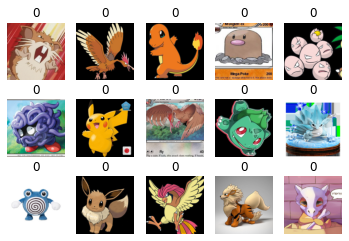

In [ ]:
k = 0
for images, labels in trainloader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    label = labels[0]
    label = label.item()
      
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.title(label)
    plt.imshow(img)

    k += 1
    if k > 14:
        break

CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, 5)
        #from size(3*256*256)--> o=(i-k)+1=(256-5)+1=252 -->(5*252*252)
        self.pool = nn.MaxPool2d(2, 2)
        #from size(5*252*252)--> o=(i-k)/s+1=(252-2)/2+1=126 -->(5*126*126)
        self.conv2 = nn.Conv2d(5, 10, 5)
        #from size(5*126*126)--> o=(i-k)+1=(126-5)+1=122 -->(10*122*122)
        #pool again from size(10*122*122)-->o=(i-k)/s+1=(122-2)/2+1=61 --> (10*61*61)
        self.fc1 = nn.Linear(37210, 750)
        self.fc2 = nn.Linear(750, 153) # 9 outputs

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 37210)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
       # x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
def get_accuracy(model, train_loader, valid_loader, train=False):
    if train:
        data = train_loader
    else:
        data = valid_loader

    correct = 0
    total = 0
    for imgs, labels in data:
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, trainset, valset, batch_size=16, learning_rate=0.01, num_epochs=1):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
    # Define the Loss function and optimizer
    # The loss function will be CrossEntropyLoss.
    # Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    iters = []
    losses = []
    train_acc =[]
    val_acc =[]
   
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        for images, labels in iter(trainloader):

          # Forward pass, backward pass, and optimize
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, trainloader, valloader, train=True)) # compute training accuracy 
        val_acc.append(get_accuracy(model, trainloader, valloader, train=False))  # compute validation accuracy
        print("epoch number ", epoch+1, "accuracy: ",train_acc[epoch])
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
train(CNN, trainset,valset,100,0.01,1)

TypeError: ignored

ALEX


In [ ]:
import os
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)


# save features to folder as tensors
# the print are for checking how much images are completed in the transformation
def features_to_folder(loader, path):
    n = 0
    for img, label in loader:
      features = alexnet.features(img)
      features_tensor = torch.from_numpy(features.detach().numpy())

      folder_name = path + '/' + str(label.item())
      if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
      torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
      n += 1
    print(n)
    print(features.shape)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
features_to_folder(valloader, '/content/sample_data/valpath')

NameError: ignored

In [ ]:
features_to_folder(trainloader, '/content/sample_data/trainpath')

In [ ]:
features_to_folder(testloader, '/content/sample_data/newtestpath')

In [ ]:
class CNN_features(nn.Module):
      def __init__(self):
          self.name = "alexfeatures"
          super(CNN_features, self).__init__()
          self.conv1 = nn.Conv2d(256, 50, 2)
          #(256*7*7)-->output(10*6*6)
          #o=(i-k)+1=(256-5)+1=252
          #No pooling
          self.conv2 = nn.Conv2d(50, 10, 2)
          # -->(10*5*5)
          self.fc1 = nn.Linear(10*5*5, 200)
          self.fc2 = nn.Linear(200, 150)

      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = F.relu(self.conv2(x))
          x = x.view(-1, 10*5*5)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

In [ ]:
newtraindata = torchvision.datasets.DatasetFolder('/content/sample_data/trainpath', loader=torch.load, extensions=('.tensor'))
newvaldata = torchvision.datasets.DatasetFolder('/content/sample_data/valpath', loader=torch.load, extensions=('.tensor'))
newtestdata = torchvision.datasets.DatasetFolder('/content/sample_data/newtestpath', loader=torch.load, extensions=('.tensor'))

In [ ]:
def trainalexfeature(model, trainset, valset, batch_size=16, learning_rate=0.01, num_epochs=1):
    #All the same from part 3
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
    # Define the Loss function and optimizer
    # The loss function will be CrossEntropyLoss.
    # Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    iters = []
    losses = []
    train_acc =[]
    val_acc =[]
   
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        for images, labels in iter(trainloader):

          # Forward pass, backward pass, and optimize
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, trainloader, valloader, train=True)) # compute training accuracy 
        val_acc.append(get_accuracy(model, trainloader, valloader, train=False))  # compute validation accuracy
        print("epoch number ", epoch+1, "accuracy: ",train_acc[epoch])
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
newmodel = CNN_features()
#proper model
trainalexfeature(newmodel, newtraindata, newvaldata, batch_size = 64, learning_rate = 0.01, num_epochs=15)